In [1]:
from PIL import Image # get the image
import cv2 as cv 
import numpy as np
import matplotlib.pyplot as plt

In [2]:
"""
Parameters used for OpenCv functions
We can find these by playing with the dashboard
"""
gaussian_w = 5 # width of the gaussian filter
gaussian_h = 5 # height of the gaussian filter
sigmaX = 5 # review what this does
canny_minval = 100 # refers to strength of edges
canny_maxval = 200
canny_aperature = 3 # this is the size of the sobel kernel, review sobel kernels


In [4]:
img_path = "../data/nashirBoard.JPG" # testing with Nashirs board
img = np.array(Image.open(img_path)) # need to convert image into a numpy array

In [5]:
gray_img = cv.cvtColor(img,cv.COLOR_BGR2GRAY) # convert go gray scale, easier to detect with a gray scale image
blur_img  = cv.GaussianBlur(gray_img,(gaussian_w,gaussian_h),sigmaX) # blurring is important for removing noise

In [6]:
"""
Here we need to try and use perspective transform
"""

'\nHere we need to try and use perspective transform\n'

In [7]:
"""
Need to find the edges and the lines for the image
"""
canny_edges = cv.Canny(blur_img,canny_minval,canny_maxval,canny_aperature) #finds the edges of the image using canny
hough_lines = cv.HoughLines(canny_edges,1,np.pi/180,150, None, 0, 0) ## review paramters here for drawing the lines

In [8]:
#code from opencv to draw lines found from hough transform on an image, takes the lines found and draws them on the image

for i in range(0, len(hough_lines)):
    rho = hough_lines[i][0][0]
    theta = hough_lines[i][0][1]
    a = np.cos(theta)
    b = np.sin(theta)
    x0 = a * rho
    y0 = b * rho
    pt1 = (int(x0 + 1000*(-b)), int(y0 + 1000*(a)))
    pt2 = (int(x0 - 1000*(-b)), int(y0 - 1000*(a)))

    blur_img = cv.line(blur_img, pt1, pt2, (255,255,255), 2, cv.LINE_AA)

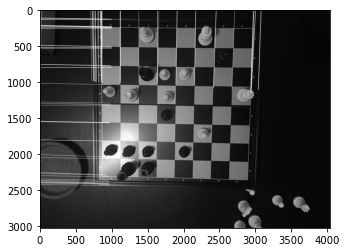

In [9]:
# show the image
plt.imshow(blur_img, cmap='gray')